In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import os
import zipfile

In [4]:
os.environ['KAGGLE_CONFIG_DIR'] = "/content/drive/MyDrive/Kaggle"

In [5]:
%cd /content/drive/MyDrive/Kaggle/

/content/drive/MyDrive/Kaggle


In [5]:
!kaggle datasets download -d hasnainjaved/melanoma-skin-cancer-dataset-of-10000-images

melanoma-skin-cancer-dataset-of-10000-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [6]:
!ls

DL.zip	kaggle.json  melanoma-skin-cancer-dataset-of-10000-images.zip


In [7]:
zip_ref = zipfile.ZipFile("melanoma-skin-cancer-dataset-of-10000-images.zip")
zip_ref.extractall("/tmp")
zip_ref.close()

In [8]:
import numpy as np
import os
import cv2
import shutil
import random as rn
from tqdm import tqdm
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [9]:
train_dir ="/tmp/melanoma_cancer_dataset/train"
test_dir = "/tmp/melanoma_cancer_dataset/test"

In [10]:
print(os.listdir("/tmp/melanoma_cancer_dataset"))

['test', 'train']


In [11]:
print("Train classes", os.listdir(train_dir))
print("Test classes", os.listdir(test_dir))

Train classes ['benign', 'malignant']
Test classes ['benign', 'malignant']


In [12]:
batch_size = 32
img_height = 224
img_width = 224

In [13]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9605 files belonging to 2 classes.
Using 7684 files for training.


In [ ]:
# # Create an empty list to store augmented data
# augmented_data = []

# # Define a data augmentation function (e.g., using ImageDataGenerator)
# def data_augmentation(images, labels):
#     # Apply your data augmentation techniques here
#     # Example: You can use the ImageDataGenerator for augmentation

#     # Create an ImageDataGenerator for augmentation
#     datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#         rotation_range=20,  # Example: Rotate images by up to 20 degrees
#         width_shift_range=0.2,  # Example: Shift width by up to 20% of image width
#         height_shift_range=0.2,  # Example: Shift height by up to 20% of image height
#         horizontal_flip=True,  # Example: Randomly flip images horizontally
#         fill_mode='nearest'  # Example: Fill in missing pixels using the nearest neighbor
#     )

#     # Apply data augmentation to each image in the batch
#     augmented_images = datagen.flow(images, labels, batch_size=len(images), shuffle=False).next()

#     return augmented_images, labels

# # Iterate through train_ds and apply data augmentation
# for batch_images, batch_labels in train_ds:
#     augmented_batch_images, _ = data_augmentation(batch_images, batch_labels)
#     augmented_data.append((augmented_batch_images, batch_labels))

# # Create a new dataset for augmented data
# augmented_ds = tf.data.Dataset.from_generator(
#     lambda: augmented_data,
#     output_signature=(
#         tf.TensorSpec(shape=(None, img_height, img_width, 3), dtype=tf.float32),
#         tf.TensorSpec(shape=(None,), dtype=tf.int32)
#     )
# )

# combined_ds = train_ds.concatenate(augmented_ds)

In [14]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 9605 files belonging to 2 classes.
Using 1921 files for validation.


In [15]:
class_names = train_ds.class_names
print(class_names)

['benign', 'malignant']


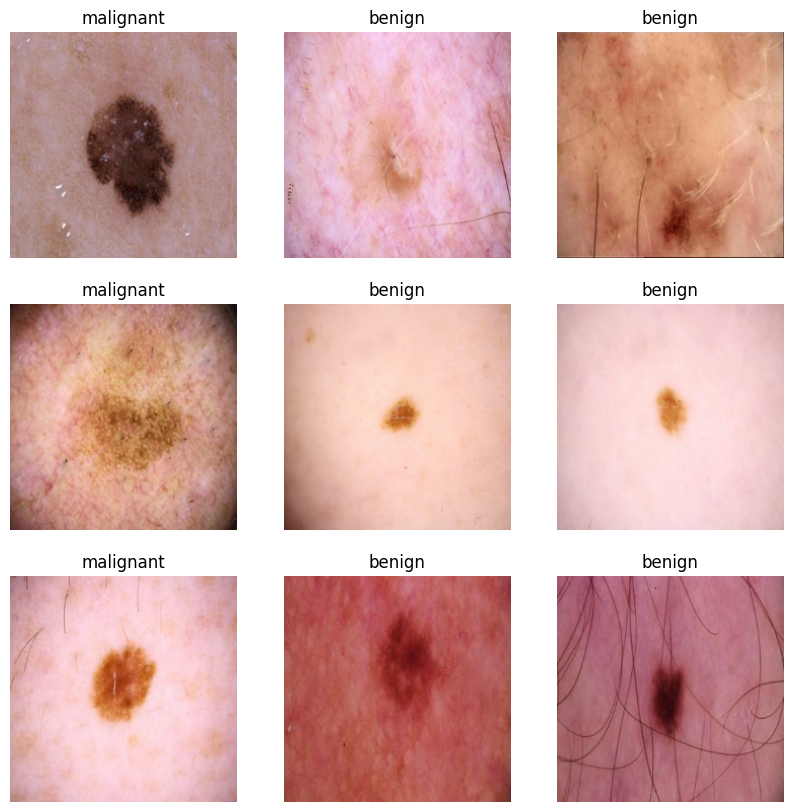

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [28]:
# Get the class names from tf.data.Dataset.class_names
class_names = train_ds.class_names

# Initialize a dictionary to store class counts
class_counts = {class_name: 0 for class_name in class_names}
# Iterate through the dataset and count images for each class
for _, labels in train_ds.as_numpy_iterator():
    for label in labels:
        class_name = class_names[label]
        class_counts[class_name] += 1

# Print the counts for each class
print(class_counts)

{'benign': 3969, 'malignant': 3715}


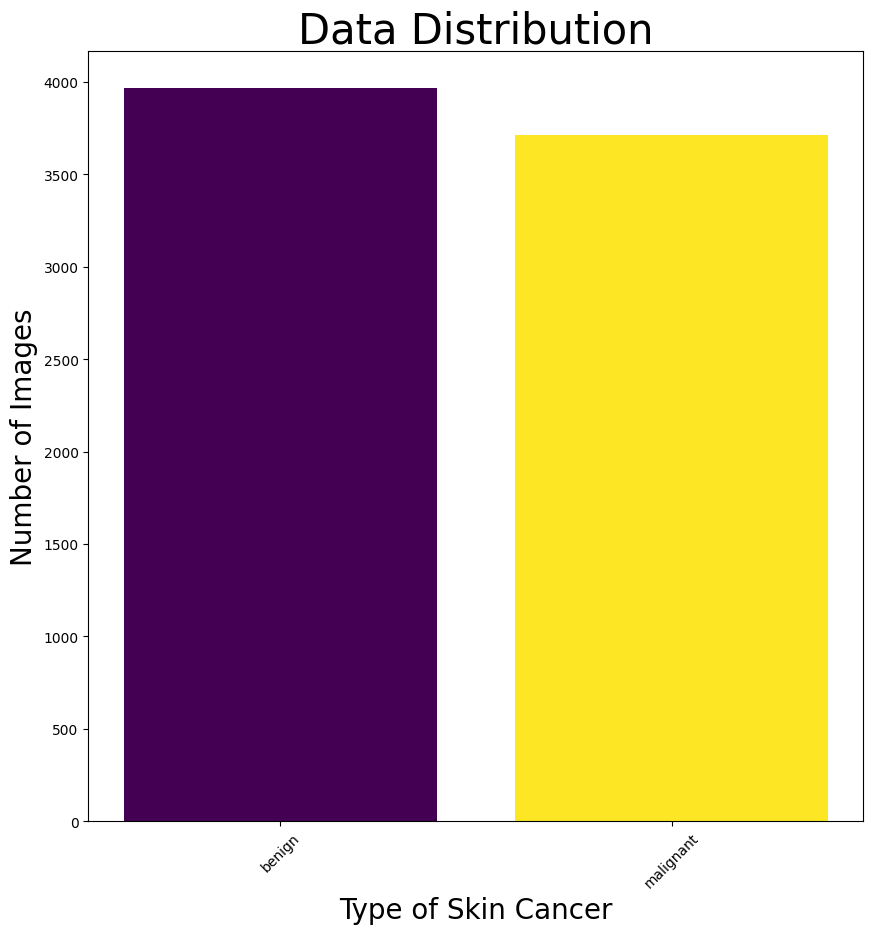

In [31]:
# plt.figure(figsize=(10,10))
# plt.title('data distribution ',fontsize=30)
# plt.ylabel('Number of image',fontsize=20)
# plt.xlabel('Type of skin cancer',fontsize=20)


# keys = class_names.keys()
# vals = class_names.values()
# print(keys)

keys = class_counts.keys()
vals = class_counts.values()

colors = plt.cm.viridis(np.linspace(0, 1, len(keys)))

plt.figure(figsize=(10, 10))
plt.bar(keys, vals, color=colors)
plt.title('Data Distribution', fontsize=30)
plt.ylabel('Number of Images', fontsize=20)
plt.xlabel('Type of Skin Cancer', fontsize=20)

# Rotate x-axis labels for better readability (if needed)
plt.xticks(rotation=45)

plt.show()
# sns.barplot(x=keys, y=vals)

Overall Mean per Channel: [181.7567 144.6088 137.8364]
Overall Standard Deviation per Channel: [55.499798 53.1673   56.726006]


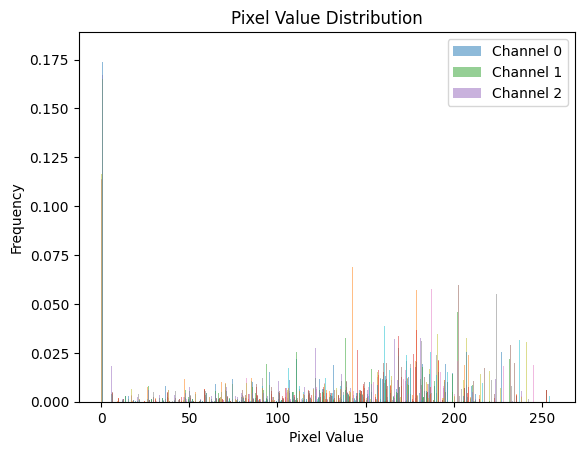

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize empty lists to store image statistics
mean_values = []
std_dev_values = []

# Iterate through the train dataset to compute statistics
for images, _ in train_ds.as_numpy_iterator():
    # Calculate mean and standard deviation per channel
    mean_per_channel = np.mean(images, axis=(0, 1, 2))
    std_dev_per_channel = np.std(images, axis=(0, 1, 2))

    mean_values.append(mean_per_channel)
    std_dev_values.append(std_dev_per_channel)

# Calculate overall mean and standard deviation across all images
overall_mean = np.mean(mean_values, axis=0)
overall_std_dev = np.mean(std_dev_values, axis=0)

# Plot histograms of pixel values for each channel
for channel in range(3):  # Assuming 3 channels (RGB)
    pixel_values = [img[:,:,channel].ravel() for img in images]
    plt.hist(pixel_values, bins=256, range=(0, 256), density=True, alpha=0.5, label=f'Channel {channel}')

plt.title('Pixel Value Distribution')
plt.xlabel('Pixel Value')
plt.ylabel('Frequency')
plt.legend(loc='upper right')

# Print image statistics
print("Overall Mean per Channel:", overall_mean)
print("Overall Standard Deviation per Channel:", overall_std_dev)

plt.show()

In [33]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 224, 224, 3)
(32,)


In [19]:
# Data Augmentation
# data_augmentation = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
#   layers.experimental.preprocessing.RandomRotation(0.2),
# ])

In [34]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
# AUTOTUNE = tf.data.AUTOTUNE

# train_ds = train_ds.cache().map(
#     lambda x, y: (data_augmentation(x, training=True), y)
# ).shuffle(1000).prefetch(buffer_size=AUTOTUNE)
# val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [35]:
vgg = VGG16(input_shape=[224, 224] + [3], weights='imagenet', include_top=False)

In [36]:
vgg.input

<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'input_1')>

In [37]:
for layer in vgg.layers:
  layer.trainable = False

In [38]:
num_classes = 2

In [39]:
x = layers.Flatten()(vgg.output)
x = layers.Dense(128, activation='sigmoid')(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(64, activation='sigmoid')(x)

# Final prediction layer
prediction = layers.Dense(num_classes, activation='sigmoid')(x)
model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
# model.compile(loss='binary_crossentropy',
#               optimizer='adam',
#               metrics=['accuracy'])

In [40]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [42]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
)

Epoch 1/10
241/241 [==============================] - 63s 167ms/step - loss: 0.2750 - accuracy: 0.8960 - val_loss: 0.2375 - val_accuracy: 0.9063
Epoch 2/10
241/241 [==============================] - 37s 154ms/step - loss: 0.2265 - accuracy: 0.9120 - val_loss: 0.2324 - val_accuracy: 0.9136
Epoch 3/10
241/241 [==============================] - 37s 155ms/step - loss: 0.2280 - accuracy: 0.9111 - val_loss: 0.2262 - val_accuracy: 0.9141
Epoch 4/10
241/241 [==============================] - 40s 167ms/step - loss: 0.2153 - accuracy: 0.9162 - val_loss: 0.2284 - val_accuracy: 0.9146
Epoch 5/10
241/241 [==============================] - 37s 156ms/step - loss: 0.2115 - accuracy: 0.9176 - val_loss: 0.2189 - val_accuracy: 0.9146
Epoch 6/10
241/241 [==============================] - 37s 156ms/step - loss: 0.2062 - accuracy: 0.9201 - val_loss: 0.2208 - val_accuracy: 0.9136
Epoch 7/10
241/241 [==============================] - 37s 156ms/step - loss: 0.2093 - accuracy: 0.9191 - val_loss: 0.2223 - val_ac

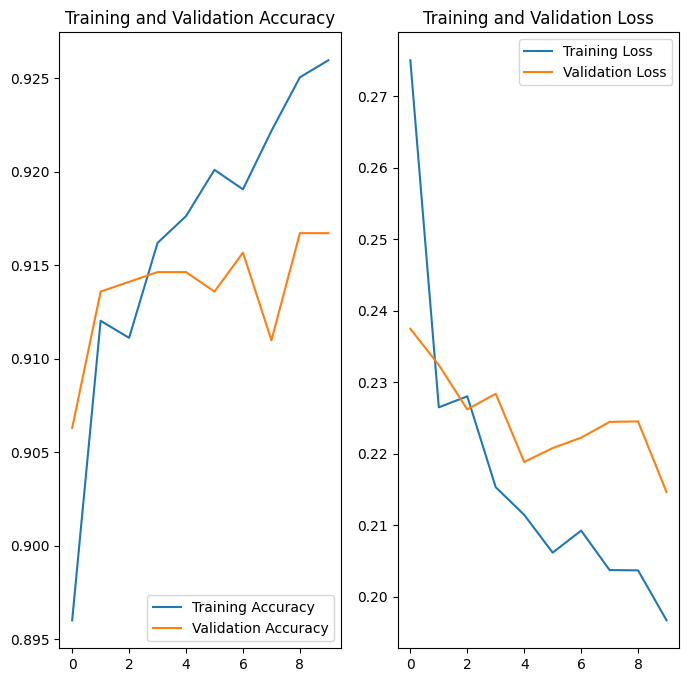

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [44]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir,
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1000 files belonging to 2 classes.


In [45]:
test_loss, test_accuracy = model.evaluate(test_ds)

# Print the test results.
print("Test loss:", test_loss)
print("Test accuracy:", test_accuracy)

32/32 [==============================] - 6s 167ms/step - loss: 0.2210 - accuracy: 0.9120
Test loss: 0.2209535837173462
Test accuracy: 0.9120000004768372


In [46]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Initialize empty lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the test dataset and make predictions
for images, labels in test_ds.as_numpy_iterator():
    # Predict using the model
    predictions = model.predict(images)

    # Convert predicted probabilities to class labels
    predicted_class = np.argmax(predictions, axis=1)

    true_labels.extend(labels)
    predicted_labels.extend(predicted_class)

# Calculate accuracy score
accuracy = accuracy_score(true_labels, predicted_labels)

# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names)

# Print the accuracy score and classification report
print("Accuracy Score:", accuracy)
print(report)

1/1 [==============================] - 0s 158ms/step
Accuracy Score: 0.912
              precision    recall  f1-score   support

      benign       0.88      0.95      0.92       500
   malignant       0.95      0.87      0.91       500

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

